# IPyParallel Toolbox 

## Concepts

In [1]:
from IPython.display import Image

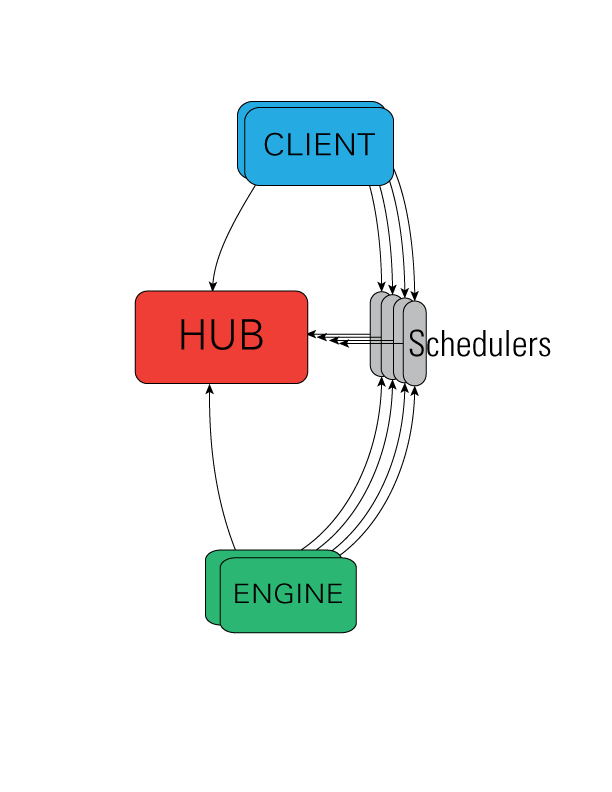

In [2]:
Image("https://ipyparallel.readthedocs.io/en/5.2.0/_images/wideView.png")

Read more about this model in the [IPyParallel documentation](https://ipyparallel.readthedocs.io/en/latest/intro.html).

* engine
* controller:
    * hub
    * schedulers
* client
* views
* [security](https://ipyparallel.readthedocs.io/en/latest/intro.html#security)

## Interactive Examples

In [3]:
from os import getpid

In [4]:
from socket import gethostname

In [5]:
from ipyparallel import Client

In [6]:
rclient = Client(profile="mylocal")

In [7]:
rclient.ids

[0, 1, 2]

### DirectView

In [8]:
dview = rclient.direct_view()

In [9]:
dview.targets

'all'

In [10]:
rclient[::2]

<DirectView [0, 2]>

In [11]:
dview.targets

'all'

In [12]:
rclient.ids

[0, 1, 2]

In [13]:
dview.block

False

In [14]:
dview.block = True

In [15]:
dview.apply(gethostname)

['orion', 'orion', 'orion']

In [16]:
dview.apply(getpid)

[2900, 2901, 2903]

In [18]:
def squared(x):
    return pow(x, 2)

In [19]:
size = int(10 ** 7)

In [20]:
%%time
serial = list(map(squared, range(size)))

CPU times: user 3.68 s, sys: 64 ms, total: 3.75 s
Wall time: 3.75 s


In [21]:
%%time
sync_res = dview.map_sync(squared, range(size))

CPU times: user 632 ms, sys: 136 ms, total: 768 ms
Wall time: 2.89 s


In [22]:
sync_res == serial

True

In [23]:
map_res = dview.map(squared, range(size))

In [24]:
map_res == serial

True

In [25]:
%%time
async_res = dview.map_async(squared, range(size), )
async_res.wait()

CPU times: user 580 ms, sys: 104 ms, total: 684 ms
Wall time: 2.88 s


In [26]:
async_res == serial

False

In [27]:
sorted(async_res) == serial

True

In [28]:
dview.block = False

In [29]:
map_res = dview.map(squared, range(size))

In [30]:
map_res == serial

False

In [31]:
sorted(map_res) == serial

True

## Remote decorators

### @remote

A function decorated with `@view.remote` executes on each engine.

In [32]:
@dview.remote(block=True)
def hello_world():
    return "hello world"

In [33]:
hello_world()

['hello world', 'hello world', 'hello world']

In [34]:
def local_echo(x):
    return str(x)

In [35]:
dview.apply_sync(local_echo, "Hello")

['Hello', 'Hello', 'Hello']

In [36]:
@dview.remote(block=True, targets=[0, 1])
def hello_world2():
    return "hello world2"

In [37]:
hello_world2()

['hello world2', 'hello world2']

### @parallel

Is a different beast, it cuts the input sequence into chunks, executes, and assembles the output.

In [38]:
import numpy as np

In [39]:
@dview.parallel(block=True)
def pmul(a, b):
    return a * b

In [40]:
arr_1 = np.arange(10)

In [41]:
arr_2 = np.arange(10)

In [42]:
arr_1 * arr_2

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])

In [43]:
pmul(arr_1, arr_2)

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])

In [44]:
@dview.parallel(block=True)
def echo(x):
    return str(x)

In [45]:
echo(range(7))

['range(0, 3)', 'range(3, 5)', 'range(5, 7)']

Since parallel functions act on sequences they can be used like map as well, acting on single elements of the sequence.

In [46]:
echo.map(range(7))

['0', '1', '2', '3', '4', '5', '6']

## Moving Data

Only operate on DirectView instances.

### `dict` interface

`dict` interface to remote namespaces. IPyKernels everywhere!

In [47]:
dview['my_var'] = [1, 2, True]

In [48]:
dview['my_var']

[[1, 2, True], [1, 2, True], [1, 2, True]]

### push & pull

In [49]:
dview.block = False

In [50]:
res = dview.push({"my_var": [1, 2, False], "x": 42})

In [51]:
res.get()

[None, None, None]

In [52]:
dview.pull("x", block=True)

[42, 42, 42]

### scatter & gather

In [53]:
dview.block = True

In [54]:
dview.scatter("y", list(range(9)))

In [55]:
dview["y"]

[[0, 1, 2], [3, 4, 5], [6, 7, 8]]

In [56]:
dview.gather("y")

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [57]:
dview.gather("y", targets=[0, 2])

[0, 1, 2, 6, 7, 8]

##  Dependencies

In [58]:
with dview.sync_imports():
    import numpy

importing numpy on engine(s)


In [59]:
from ipyparallel import require

```python
@require("numpy")
def f(...):
    numpy.
```

```python
@require(np)
def f(...):
    np.
```

## Magics

%px

%%px

%pxconfig

%pxresult

In [ ]:
dview.execute()